In [1]:
# torch的nn模型

import numpy as np
import torch
from torch import optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # y
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # x

t_c = torch.tensor(t_c).unsqueeze(1) # 增维用于batch使用，注意要在后面加维度，因为模型每次传入的是1个数字，共11组
t_u = torch.tensor(t_u).unsqueeze(1)

print(t_c.shape)
t_c

torch.Size([11, 1])


tensor([[ 0.5000],
        [14.0000],
        [15.0000],
        [28.0000],
        [11.0000],
        [ 8.0000],
        [ 3.0000],
        [-4.0000],
        [ 6.0000],
        [13.0000],
        [21.0000]])

In [3]:
# 使用训练集和测试集

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  2,  0,  9,  4,  7,  5,  6,  8]), tensor([1, 3]))

In [4]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [5]:
# 使用nn构建线性回归

import torch.nn as nn

# 构建模型时的输入和输出形状不包含batch_size
linear_model = nn.Linear(1,1) # input shape and output shape

In [6]:
# 进行一步输出（注意此时为模型初始化参数，并未训练）
linear_model(val_t_un)

tensor([[3.7382],
        [5.8654]], grad_fn=<AddmmBackward0>)

In [7]:
linear_model(train_t_un)

tensor([[4.7609],
        [3.9264],
        [2.0855],
        [4.1064],
        [3.7709],
        [0.9483],
        [3.1655],
        [1.9382],
        [3.1246]], grad_fn=<AddmmBackward0>)

In [8]:
# 相当于之前的params参数
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.8182]], requires_grad=True),
 Parameter containing:
 tensor([-0.8353], requires_grad=True))

In [9]:
optimizer = optim.SGD(
    linear_model.parameters(), # <2> parameters()包含了weight和bias
    lr=1e-2)

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.8182]], requires_grad=True),
 Parameter containing:
 tensor([-0.8353], requires_grad=True)]

In [11]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [12]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [13]:
# 根据训练结果来看，在验证集上出现了过拟合，正常是要中止训练的。不过由于演示用的数据太少，不一定要取中间的数据
training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = train_t_un,
    t_u_val = val_t_un, 
    t_c_train = train_t_c,
    t_c_val = val_t_c)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 64.1621, Validation loss 297.6230
Epoch 1000, Training loss 3.8100, Validation loss 12.9762
Epoch 2000, Training loss 2.9522, Validation loss 6.6700
Epoch 3000, Training loss 2.9117, Validation loss 5.6108

Parameter containing:
tensor([[5.0237]], requires_grad=True)
Parameter containing:
tensor([-15.9349], requires_grad=True)


In [14]:
training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # 使用torch自带的mse loss
    t_u_train = train_t_un,
    t_u_val = val_t_un, 
    t_c_train = train_t_c,
    t_c_val = val_t_c)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 2.9117, Validation loss 5.6104
Epoch 1000, Training loss 2.9098, Validation loss 5.3954
Epoch 2000, Training loss 2.9097, Validation loss 5.3493
Epoch 3000, Training loss 2.9097, Validation loss 5.3393

Parameter containing:
tensor([[5.0540]], requires_grad=True)
Parameter containing:
tensor([-16.0924], requires_grad=True)


In [15]:
# Sequential 模型

seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [16]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [17]:
# 另一种方式构建Sequential模型
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un, 
    t_c_train = train_t_c,
    t_c_val = val_t_c)
    
print('output', seq_model(val_t_un)) # 预测值
print('answer', val_t_c) # 实际值
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 1.8782, Validation loss 9.7152
Epoch 1000, Training loss 1.7759, Validation loss 7.8924
Epoch 2000, Training loss 1.7039, Validation loss 6.7091
Epoch 3000, Training loss 1.6517, Validation loss 5.9074
Epoch 4000, Training loss 1.6135, Validation loss 5.3502
Epoch 5000, Training loss 1.5856, Validation loss 4.9568
output tensor([[11.4914],
        [26.0974]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [28.]])
hidden tensor([[-0.0065],
        [-0.0084],
        [-0.0053],
        [-0.0155],
        [-0.0052],
        [-0.0130],
        [-0.0081],
        [-0.0017]])


<IPython.core.display.Javascript object>


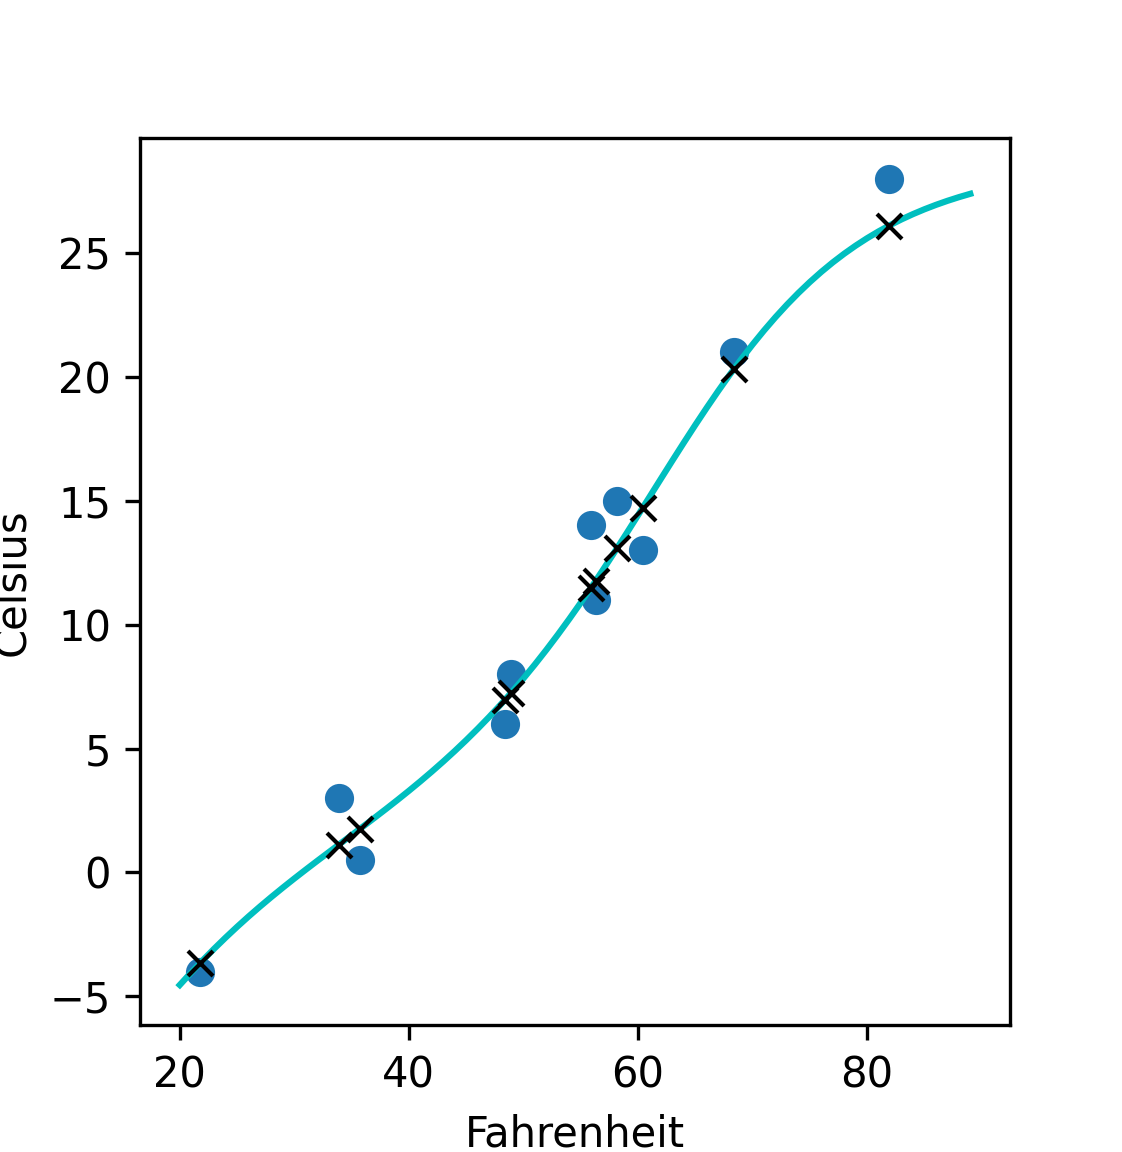

In [23]:
%matplotlib notebook

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=200)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [24]:
## Exercise

# 1.修改隐藏层神经元数量

neuron_count = 20

seq_model = nn.Sequential(
            nn.Linear(1, neuron_count), # <1>
            nn.Tanh(),
            nn.Linear(neuron_count, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=1, bias=True)
)

Epoch 1, Training loss 1.9710, Validation loss 5.4286
Epoch 1000, Training loss 1.8715, Validation loss 4.2175
Epoch 2000, Training loss 1.8036, Validation loss 3.5438
Epoch 3000, Training loss 1.7512, Validation loss 3.1953
Epoch 4000, Training loss 1.7052, Validation loss 3.0307
Epoch 5000, Training loss 1.6669, Validation loss 2.9769
output tensor([[11.5914],
        [27.6094]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [28.]])


<IPython.core.display.Javascript object>


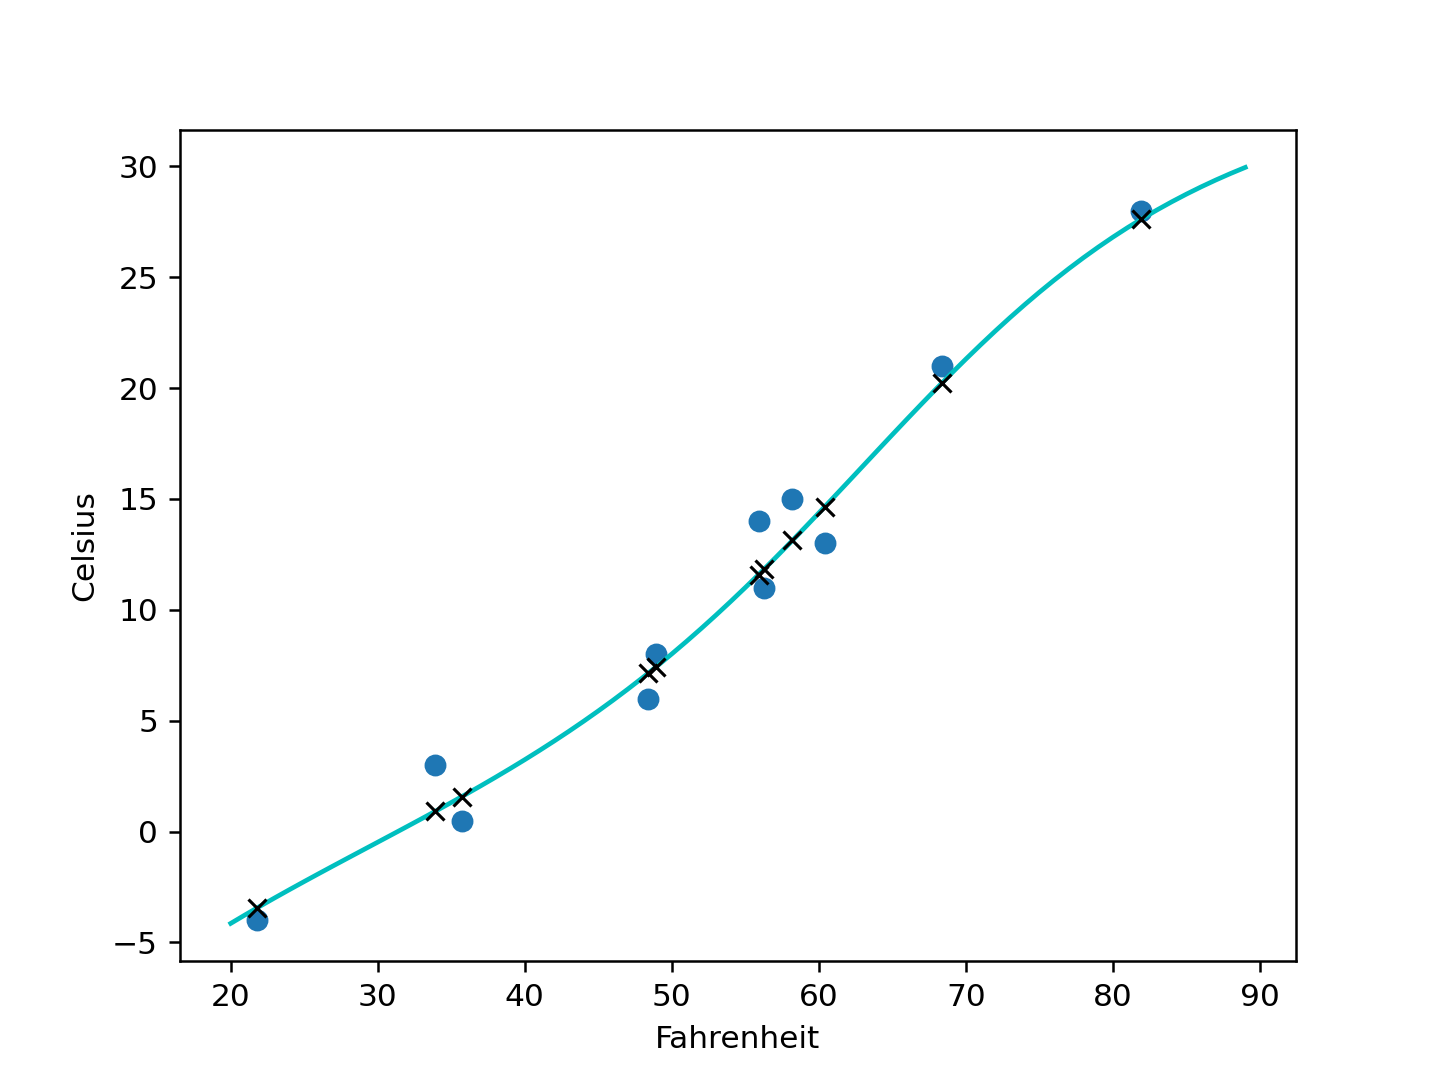

In [27]:
%matplotlib notebook

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # 通过实践，在本模型中步长才是决定收敛速度的关键

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un, 
    t_c_train = train_t_c,
    t_c_val = val_t_c)
    
print('output', seq_model(val_t_un)) # 预测值
print('answer', val_t_c) # 实际值
# print('hidden', seq_model.hidden_linear.weight.grad)

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')